In [85]:
## Main Simulation

In [86]:
import heapq
import random
import scipy.stats as sts
from operator import attrgetter
import numpy as np

In [87]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.

    Attributes
    ----------
    <include your list and description here>

    '''

    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        return self.timestamp < other.timestamp

    def run(self, schedule):
        try:
            self.function(schedule, *self.args, **self.kwargs)
        except:
            print('Error running event:')
            # BUG BUG BUG 🐞🐞🐞 PATCHED UP WITH A TRY-EXCEPT 🐞🐞🐞
            print(self.function, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.

    The `now` attribute contains the time at which the last event was run.

    Attributes
    ----------
    <include your list and description here>

    '''

    def __init__(self):
        self.now = 0
        self.priority_queue = []

        # Things to calculate
        self.waiting_times = []
        self.response_times = []

        # For empirical analysis comparison
        self.queue_lengths = []
        self.customers_in_system = []
        self.max_queue_length = 0

    def add_event_at(self, timestamp, function, *args, **kwargs):
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))

    def add_event_after(self, interval, function, *args, **kwargs):
        self.add_event_at(self.now + interval, function, *args, **kwargs)

    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        
        event = heapq.heappop(self.priority_queue)        
        self.now = event.timestamp
        event.run(self)

    def __repr__(self):
        return (
                f'Schedule() at time {self.now}min ' +
                f'with {len(self.priority_queue)} events in the queue')

    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')



In [88]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.

    Attributes
    ----------
    <include your list and description here>

    '''

    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        return self.timestamp < other.timestamp

    def run(self, schedule):
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.

    The `now` attribute contains the time at which the last event was run.

    Attributes
    ----------
    <include your list and description here>

    '''

    def __init__(self):
        self.now = 0
        self.priority_queue = []

        # Things to calculate
        self.waiting_times = []
        self.response_times = []

        # For empirical analysis comparison
        self.queue_lengths = []
        self.customers_in_system = []
        self.max_queue_length = 0

    def add_event_at(self, timestamp, function, *args, **kwargs):
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))

    def add_event_after(self, interval, function, *args, **kwargs):
        self.add_event_at(self.now + interval, function, *args, **kwargs)

    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        
        event = heapq.heappop(self.priority_queue)        
        self.now = event.timestamp
        event.run(self)

    def __repr__(self):
        return (
                f'Schedule() at time {self.now}min ' +
                f'with {len(self.priority_queue)} events in the queue')

    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')



In [120]:
class Customer:
    def __init__(self, arrival_time, wait_time, start_service_time, finish_service_time, m_arrival_time, manager_wait_time, m_start_service_time, m_finish_service_time):
        self.arrival_time = arrival_time
        self.wait_time = wait_time
        self.start_service_time = start_service_time
        self.finish_service_time = finish_service_time
        self.m_arrival_time = m_arrival_time
        self.manager_wait_time = manager_wait_time
        self.m_start_service_time = m_start_service_time
        self.m_finish_service_time = m_finish_service_time 

        # response time = time spent in the system, from arrival to departure
    def get_metrics(self):
        self.total_wait_time = self.wait_time
        
        if self.manager_wait_time != 0:
            self.total_wait_time += self.manager_wait_time
        
        self.response_time = self.finish_service_time - self.arrival_time

        if self.m_finish_service_time != 0:
            self.response_time += (self.m_finish_service_time - self.m_arrival_time)



class Queue_MG1:
    def __init__(self, service_distribution, queue_number, manager, run_until):

        self.service_distribution = service_distribution
        self.people_in_queue = 0
        self.people_being_served = 0

        self.queue_number = queue_number
        self.run_until = run_until

        # variables to keep track of the time spent in the queue (future metrics)
        self.join = 0
        self.arrival_times = []
        self.start_serving_times = []
        self.finish_serving_times = []

        self.start_serving = 0
        self.finish_serving = 0
        self.wait_time = 0

        self.current_customers = []
        self.serving_customers = []
        self.served_customers = []

        self.max_queue_length = 0

        

    def add_customer(self, schedule, manager):
        # Add the customer to the queue
        
        
        if self.run_until >= schedule.now:
            customer = Customer(schedule.now, 0, 0, 0, 0, 0, 0, 0)
            self.current_customers.append(customer)
            self.people_in_queue += 1
            
            print(
                f'⏱{schedule.now:5.2f}min: Add customer to queue {self.queue_number}.  '
                f' 🧍🏾‍♀️People in the queue: {self.people_in_queue}')

            if self.people_being_served < 1:
                # This customer can be served immediately
                schedule.add_event_after(0, self.start_serving_customer, manager)



    def start_serving_customer(self, schedule, manager):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        
        # choose the customers with the earliest arrival time
        if self.current_customers != []:
            self.curr_customer = min(self.current_customers, key=attrgetter("arrival_time"))

            # update the time they got served
            self.curr_customer.start_service_time = schedule.now
            # update the wait_time of the customer
            self.curr_customer.wait_time = self.curr_customer.start_service_time - self.curr_customer.arrival_time

            # move the customer from the waiting to the serving list
            self.current_customers.remove(self.curr_customer)
            self.serving_customers.append(self.curr_customer)

        
            print(
                f'⏱{schedule.now:5.2f}min: Start serving customer in queue {self.queue_number}. '
                f' 🧍🏾‍♀️People in the queue number {self.queue_number}: {self.people_in_queue}')
            # Schedule when the server will be done with the customer
            schedule.add_event_after(
                self.service_distribution.rvs(),
                self.finish_serving_customer, manager)

    def finish_serving_customer(self, schedule, manager):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.serving_customers != []:
            # choose the customer with the earliest start service time
            self.curr_customer = min(self.serving_customers, key=attrgetter("start_service_time"))
            # update when they finished getting served
            self.curr_customer.finish_service_time = schedule.now
            # remove the customer from the queue
            self.serving_customers.remove(self.curr_customer)
            # add the customer to the served list
            self.served_customers.append(self.curr_customer)
            
            print(
                f'⏱{schedule.now:5.2f}min: Stop serving customer in queue number {self.queue_number}.')

            if self.people_in_queue > 0:
                # There are more people in the queue so serve the next customer
                schedule.add_event_after(0, self.start_serving_customer, manager)

            # 5% chance that the person who just got served will join the manager queue
            if random.random() < 0.05:

                # add the customer to the manager queue
                self.send_customer_to_manager(schedule, manager, self.curr_customer)
                
                # schedule the manager service time
                # print()
                # schedule.add_event_after(0, self.start_serving_customer, manager)


    
    def send_customer_to_manager(self, schedule, manager, customer):
        # with a 5% chance likelihood, the person who just got served will join the Manager queue
        # if the manager is not busy, the person will be served immediately
        # if the manager is busy, the person will join the queue
        # the manager's service distribution is the same as the queue's
        # there is only one manager.
        manager.add_customer(schedule, customer)

    



class Manager():
    # replica of the Queue_MG1 class, but with a different name
    # should be refactored, probably through inheritance
    def __init__(self, service_distribution):
        self.service_distribution = service_distribution
        self.people_in_queue = 0
        self.people_being_served = 0
        
        self.start_serving = 0
        self.finish_serving = 0

        self.m_current_customers = []
        self.m_serving_customers = []
        self.m_served_customers = []


    def add_customer(self, schedule, customer):

        # Add the customer to the queue
        self.m_current_customers.append(customer)
        # print the values of all of the attributes of the customer
        # customer manager arrival time is now
        customer.m_arrival_time = schedule.now
        
        self.people_in_queue += 1
        print( f'⏱{schedule.now:5.2f}min: Add customer to manager queue. '
         f'People in manager queue {self.people_in_queue}')
        
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # choose the customer who arrived first to the manager queue
        self.people_in_queue -= 1
        self.people_being_served += 1

        if self.m_current_customers != []:
            self.curr_customer = min(self.m_current_customers, key=attrgetter("m_arrival_time"))
            
            
            # update the time the customer started being served
            self.curr_customer.m_start_service_time = schedule.now

            # update the wait time of the customer
            self.curr_customer.m_wait_time = self.curr_customer.m_start_service_time - self.curr_customer.m_arrival_time


            # remove the customer from the queue to the serving list
            self.m_current_customers.remove(self.curr_customer)
            self.m_serving_customers.append(self.curr_customer)
            

            print( f'⏱{schedule.now:5.2f}min: Manager serving person')
            schedule.add_event_after(self.service_distribution.rvs(), 
            self.finish_serving_customer)

            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the Manager
        self.people_being_served -= 1

        if self.m_serving_customers != []:

            # choose the customer with the earliest start service time
            self.curr_customer = min(self.m_serving_customers, key=attrgetter("m_start_service_time"))
            # update when they finished getting served
            self.curr_customer.m_finish_service_time = schedule.now
            # remove the customer from the queue
            self.m_serving_customers.remove(self.curr_customer)
            # add the customer to the served list
            self.m_served_customers.append(self.curr_customer)

            print( f'⏱{schedule.now:5.2f}min: Manager done serving person'
            f'People in manager queue {self.people_in_queue}')

            if self.people_in_queue > 0:
                # There are more people in the queue so serve the next customer
                schedule.add_event_after(0, self.start_serving_customer)
    


class GroceryStore_MG1:
    # not MG1 but MGC? # since it's a system of MG1 queues? Or,  c*MG1?
    def __init__(self, arrival_distribution, service_distribution, manager_serv_distribution, num_queues, run_until):

        self.arrival_distribution = arrival_distribution
        self.run_until = run_until

        # making it from an MG1 queue but really, it's a GG1 queue
        self.manager = Manager(manager_serv_distribution)

        self.queues = {}
        for i in range(num_queues):
            self.queues[i] = Queue_MG1(service_distribution, i, self.manager, self.run_until)

    def add_customer(self, schedule):
        longest_queue = max(self.queues.values(), key=attrgetter("people_in_queue")).people_in_queue 
        schedule.max_queue_length = max(schedule.max_queue_length, longest_queue)


        # only adds customers until 8 PM
        if self.run_until >= schedule.now:
            # find the queue with the smallest number of people
            self.min_queue = min(self.queues.values(), key=attrgetter("people_in_queue"))

            # Add this customer to that queue
            self.min_queue.add_customer(schedule, self.manager)
            # Schedule when to add another customer
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)



    def run(self, schedule):
        # Schedule the first customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(), 
            self.add_customer)

    def get_people_in_system(self):
            # go through each queue and add all people waiting and served
            self.people_in_system = 0
            for q in self.queues.values():
                self.people_in_system += q.people_in_queue
                self.people_in_system += q.people_being_served
            # also add people in the manager queue or being served by manager
            self.people_in_system += self.manager.people_in_queue
            self.people_in_system += self.manager.people_being_served
            return self.people_in_system

    def get_metrics(self, schedule):
        # get the metrics for each queue
        # get all the customers from all the queues
        self.avg_wait_time = 0
        self.avg_response_time = 0
        self.num_total_customers = 0


        for q in self.queues.values():
            for c in q.served_customers:
                self.num_total_customers += 1
                c.get_metrics()
                self.avg_wait_time += c.total_wait_time
                self.avg_response_time += c.response_time
        
        self.avg_wait_time /= self.num_total_customers
        self.avg_response_time /= self.num_total_customers
        self.max_queue_length = schedule.max_queue_length
    



def run_simulation_MG1(arrival_distribution, service_distribution, manager_serv_distribution, num_queues, run_until):
    schedule = Schedule()
    grocery_store = GroceryStore_MG1(arrival_distribution, service_distribution, manager_serv_distribution, num_queues, run_until)
    grocery_store.run(schedule)
    
    times = []
    population = []
    # allows events to run while priority queue is not empty
    while schedule.priority_queue:
        # get minute from schedule.now

        if int(schedule.now) % 2 == 0:
            times.append(schedule.now)
            # for all queues get number of people in system
            people_in_system = grocery_store.get_people_in_system()
            population.append(people_in_system)

        schedule.run_next_event()
    grocery_store.max_customers_in_system = max(population)
    
    grocery_store.get_metrics(schedule)
    # print(population)

    print(f'Finished running simulation for {run_until} minutes for {num_queues} queues')
    return grocery_store


In [121]:
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=np.sqrt(1))
manager_serv_distribution = sts.norm(loc=5, scale=np.sqrt(2))
number_queues = 5


duration = (20 - 9)*60
print(duration)

grocery_store = run_simulation_MG1(arrival_distribution, service_distribution, manager_serv_distribution, number_queues, duration)

660
⏱ 0.46min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 1
⏱ 0.46min: Start serving customer in queue 0.  🧍🏾‍♀️People in the queue number 0: 0
⏱ 1.65min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 1
⏱ 1.74min: Add customer to queue 1.   🧍🏾‍♀️People in the queue: 1
⏱ 1.74min: Start serving customer in queue 1.  🧍🏾‍♀️People in the queue number 1: 0
⏱ 2.83min: Add customer to queue 1.   🧍🏾‍♀️People in the queue: 1
⏱ 2.85min: Add customer to queue 2.   🧍🏾‍♀️People in the queue: 1
⏱ 2.85min: Start serving customer in queue 2.  🧍🏾‍♀️People in the queue number 2: 0
⏱ 4.53min: Add customer to queue 2.   🧍🏾‍♀️People in the queue: 1
⏱ 4.80min: Stop serving customer in queue number 0.
⏱ 4.80min: Start serving customer in queue 0.  🧍🏾‍♀️People in the queue number 0: 0
⏱ 5.19min: Stop serving customer in queue number 1.
⏱ 5.19min: Start serving customer in queue 1.  🧍🏾‍♀️People in the queue number 1: 0
⏱ 5.52min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 1
⏱ 5.91min:

660
⏱ 0.83min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 1
⏱ 0.83min: Start serving customer in queue 0.  🧍🏾‍♀️People in the queue number 0: 0
⏱ 1.17min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 1
⏱ 3.32min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 2
⏱ 3.39min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 3
⏱ 3.41min: Stop serving customer in queue number 0.
⏱ 3.41min: Start serving customer in queue 0.  🧍🏾‍♀️People in the queue number 0: 2
⏱ 3.81min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 3
⏱ 4.57min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 4
⏱ 4.58min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 5
⏱ 5.76min: Add customer to queue 0.   🧍🏾‍♀️People in the queue: 6
⏱ 5.96min: Stop serving customer in queue number 0.
⏱ 5.96min: Start serving customer in queue 0.  🧍🏾‍♀️People in the queue number 0: 5
⏱ 8.84min: Stop serving customer in queue number 0.
⏱ 8.84min: Start serving customer in queue 0.  🧍🏾‍♀️People i

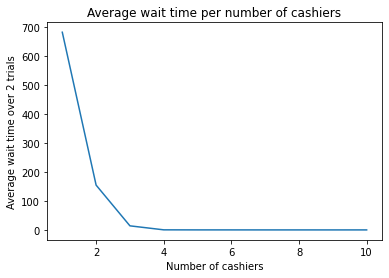

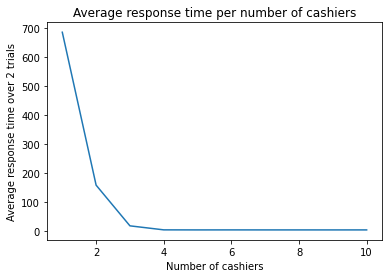

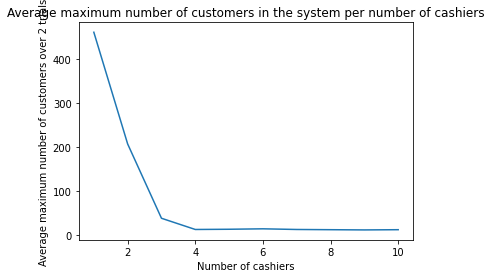

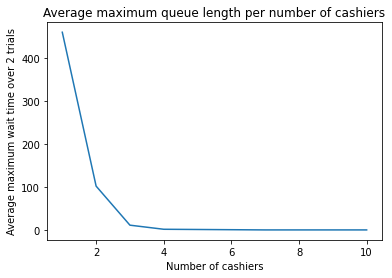

In [130]:
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=np.sqrt(1))
manager_serv_distribution = sts.norm(loc=5, scale=np.sqrt(2))


duration = (20 - 9)*60
print(duration)


trials = 2


# iterate through the possible queue lengths
# fill array with 10 zeros

wait_times = np.zeros(10)
response_times = np.zeros(10)
max_customers_in_system = np.zeros(10)
max_queue_length = np.zeros(10)

for n in range(1, 11):
    for trial in range(trials):
        gc = run_simulation_MG1(arrival_distribution, service_distribution, manager_serv_distribution, n, duration)
        wait_times[n-1] += gc.avg_wait_time
        response_times[n-1] += gc.avg_response_time
        max_customers_in_system[n-1] += gc.max_customers_in_system
        max_queue_length[n-1] += gc.max_queue_length
        
    # find average metrics across trials
    wait_times[n-1] /= trials
    response_times[n-1] /= trials
    max_customers_in_system[n-1] /= trials
    max_queue_length[n-1] /= trials

print(wait_times)
print(response_times)
print(max_customers_in_system)
print(max_queue_length)

num_qs = np.linspace(1, 10, 10)

import matplotlib.pyplot as plt
plt.plot(num_qs, wait_times)
plt.title('Average wait time per number of cashiers')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average wait time over {trials} trials')
plt.show()


plt.plot(num_qs, response_times)
plt.title('Average response time per number of cashiers')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average response time over {trials} trials')
plt.show()


plt.plot(num_qs, max_customers_in_system)
plt.title('Average maximum number of customers in the system per number of cashiers')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average maximum number of customers over {trials} trials')
plt.show()

plt.plot(num_qs, max_queue_length)
plt.title('Average maximum queue length per number of cashiers')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average maximum wait time over {trials} trials')
plt.show()

# plot metrics
# x = number of queues
# y = avg wait time, avg response time, max queue length, max people in system



